# TCC2

## Engenharia de Sistemas - UFMG
---
Autor: Thullio Debortoli Moreira Zanetti

Orientador: Frederico Gadelha Guimarães

## 1) Acesso ao Google Drive

In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp52f0_4j_/pubring.gpg' created
gpg: /tmp/tmp52f0_4j_/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


KeyboardInterrupt: ignored

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

## 2) Limpar  e transformar base de dados

In [0]:
import sqlite3
import pandas as pd 
import numpy as np
from google.colab import files
import matplotlib.pylab as plt
%matplotlib inline

In [0]:
#df = pd.read_csv(files.download("drive/UFMG/TCC2/Algoritmo/database/loan.csv"), sep=',', usecols = ["loan_status", "loan_amnt", "term", "int_rate"]) 
#['Fully Paid', 'Charged Off', 'Current', 'Default',
#       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
#       'Does not meet the credit policy. Status:Fully Paid',
#       'Does not meet the credit policy. Status:Charged Off', 'Issued']
conn = sqlite3.connect('drive/UFMG/TCC2/Algoritmo/database/database.sqlite')
to_parse = ['issue_d' , 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
df_db = pd.read_sql_query("select * from loan where loan_status = 'Fully Paid' OR loan_status = 'Charged Off' OR loan_status = 'Default'", con=conn, parse_dates = to_parse)

Pimeiramente são excluidas as colunas e as linhas que contém mais de 50% dos seus valores nulos, pois não possuem informação suficiente para o problema

In [0]:
df = df_db
df.dropna(axis=1, thresh=int(df.shape[0]*0.5), inplace=True)
df.dropna(axis=0, thresh=int(df.shape[1]*0.5), inplace=True)

Das colunas restantes, como para predição são utilizados apenas dados coletados anteriormente à concessão do empréstimo, algumas colunas não possuem sentido para o problema. Outras são campos aberto e também não agragam valor.


*   Colunas excluídas: index, id, member_id, issue_d, initial_list_status, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, collections_12_mths_ex_med, pymnt_plan, url, zip_code, addr_state, grade, emp_title, purpose, policy_code, title

*   Colunas mantidas: loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, sub_grade, emp_length, home_ownership, annual_inc, verification_status, loan_status, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, recoveries,  application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim

Depois verifica-se quais colunas são do tipo texto para que sejam transformadas.



In [0]:
columns_to_keep =  ['loan_amnt',
                    'funded_amnt',
                    'funded_amnt_inv',
                    'term',
                    'int_rate',
                    'installment',
                    'sub_grade',
                    'emp_length',
                    'home_ownership',
                    'annual_inc',
                    'verification_status',
                    'loan_status',
                    'dti',
                    'delinq_2yrs',
                    'earliest_cr_line',
                    'inq_last_6mths',
                    'open_acc',
                    'pub_rec',
                    'revol_bal',
                    'revol_util',
                    'total_acc',
                    'recoveries',
                    'application_type',
                    'acc_now_delinq',
                    'tot_coll_amt',
                    'tot_cur_bal',
                    'total_rev_hi_lim']
df = df[columns_to_keep]
#df.dtypes  #get column types

**Segue relação de colunas e transformações a serem realizadas:**

Coluna | Ex valor atual | Ex novo valor | Novo nome
:---: | :---: | :---: | :---:
term |  36 m | 36 | -
int_rate | 10% | 0.1 | -
sub_grade | [A1 - G5] | [35 - 1] | grade
emp_length | 1 year | 1 | -
home_ownership | own/other | 1/0 |  own_home              
verification_status | Verified/Not Verified | 1/0 | verified
loan_status | Fully Paid/Charged off | 1/0 | fully_paid
earliest_cr_line | DateTime | Month/Year |  -
revol_util | 10% | 0.1 | -
application_type | INDIVIDUAL/JOINT | 1/0 | individual

In [0]:
#Define range transformation
grades = {'A1' : 35, 'A2' : 34, 'A3' : 33, 'A4' : 32, 'A5' : 31, 'B1' : 30, 'B2' : 29, 'B3' : 28, 'B4' : 27, 'B5' : 26, 'C1' : 25, 'C2' : 24, 'C3' : 23, 'C4' : 22, 'C5' : 21, 'D1' : 20, 'D2' : 19, 'D3' : 18, 'D4' : 17, 'D5' : 16, 'E1' : 15, 'E2' : 14, 'E3' : 13, 'E4' : 12, 'E5' : 11, 'F1' : 10, 'F2' : 9, 'F3' : 8, 'F4' : 7, 'F5' : 6, 'G1' : 5, 'G2' : 4, 'G3' : 3, 'G4' : 2, 'G5' : 1}

#applying transformations
df['term'] = df['term'].str.split(' ').str[1]
df['int_rate'] = (df['int_rate'].str.split('%').str[0]).astype(float)/100.
df["sub_grade"] = df["sub_grade"].replace(grades)
# extract numbers from emp_length and fill missing values with the median
df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
df['emp_length'] = df['emp_length'].fillna(df.emp_length.median())
df['home_ownership'] = df['home_ownership'].apply(lambda x : 1 if x == 'OWN' else 0)
df['verification_status'] = df['verification_status'].apply(lambda x : 0 if x == 'Not Verified' else 1)
df['loan_status'] = df['loan_status'].apply(lambda x : 1 if x == 'Fully Paid' else 0)
df['earliest_cr_line'] = df['earliest_cr_line'].dt.to_period('M')
df['revol_util'] = (df['revol_util'].str.split('%').str[0]).astype(float)/100.
df['application_type'] = df['application_type'].apply(lambda x : 1 if x == 'INDIVIDUAL' else 0)

df = df.rename(index=str, columns={"loan_status": "fully_paid", 
                              "sub_grade": "grade", 
                              "home_ownership" : "own_home", 
                              "verification_status" : "verified", 
                              "application_type" : "individual"})

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

A partir das características restantes, foram criadas novas caracteristicas em busca de uma informação melhor. As colunas funded_amnt e funded_amnt_inv foram substituídas pelo percentual dos valores em relação ao montante do empréstimo.

In [0]:
df['funded_amnt'] = df['funded_amnt']/df['loan_amnt']
df['funded_amnt_inv'] = df['funded_amnt_inv']/df['loan_amnt']

Após a transformação dos dados, os mesmos são filtrados de acordo com a correlação dos mesmos com a saída. São retirados as variáveis com valor absoluto de correlação menor que 0,01 com a saída. Após este filtro, retaram 15 parâmetros de entrada finais.

In [0]:
df = df.fillna(0)
df = df[df.corr()['fully_paid'][np.absolute(df.corr()['fully_paid']) > 0.01].index]

# 3) Modelos de IA

10% do dataset sera separado para testes e comparação dos resultados. Todos os modelos serão treinados utilizando o método K-fold dividindo-se o dataset em 10 partes iguais.

## 3.1) Decision Tree

A primeira técnica de inteligência artificial a ser aplicada é a de uma árvore de decisão. 

In [0]:
from sklearn.model_selection import train_test_split

# Define entrada e saída para treinamento e teste (10% da amostra)
y = df['fully_paid']
X = df.drop(['fully_paid'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [0]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt

In [0]:
#Treinar modelo utilizando GridSearchCV e variando profundidade da arvore de 3 a 20, com 10 folds
'''Algoritmo utilizado para gerar o classificador:
parameters = {'max_depth':range(3,20)}
decTreeClf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4, cv = 10)
decTreeClf.fit(X=X_train, y=y_train)

with open('drive/UFMG/TCC2/Algoritmo/classifiers/decisionTreeCLF.pkl', 'wb') as f:
    pickle.dump(decTreeClf, f) # save the object to a file'''

with open('drive/UFMG/TCC2/Algoritmo/classifiers/decisionTreeCLF.pkl', 'rb') as f:
    decTreeClf = pickle.load(f)

tree_model = decTreeClf.best_estimator_
print (decTreeClf.best_score_, decTreeClf.best_params_)

(0.9123493750762222, {'max_depth': 3})


Type I error (FP): 0.09013
Type II error (FN): 0.00000
Acuracy: 0.90987
ROC_AUC_Score: 0.83844




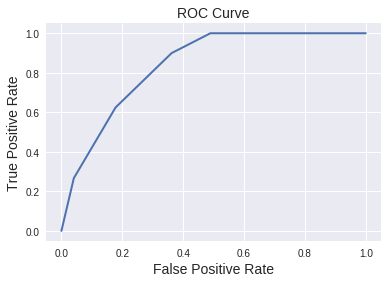

In [0]:
y_predict_tree = decTreeClf.predict(X_test)
y_difference_tree = y_test - y_predict_tree
y_pred_proba = decTreeClf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print 'Type I error (FP): {0:.5f}'.format(float(y_difference_tree[y_difference_tree == -1].shape[0])/float(y_difference_tree.shape[0]))
print 'Type II error (FN): {0:.5f}'.format(float(y_difference_tree[y_difference_tree == 1].shape[0])/float(y_difference_tree.shape[0]))
print 'Acuracy: {0:.5f}'.format(float(y_difference_tree[y_difference_tree == 0].shape[0])/float(y_difference_tree.shape[0]))
print 'ROC_AUC_Score: {0:.5f}\n\n'.format(metrics.roc_auc_score(y_test, y_pred_proba))
plt.plot(fpr,tpr, linewidth=2)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=14)
plt.show()

In [0]:
# Codigo para conseguir printar datas
%%bash
/usr/bin/yes | apt-get install graphviz
pip install --upgrade graphviz
/usr/bin/yes | pip uninstall pyparsing
pip install -Iv https://pypi.python.org/packages/source/p/pyparsing/pyparsing-1.5.7.tar.gz
pip install --upgrade pydot
pip install pydotplus

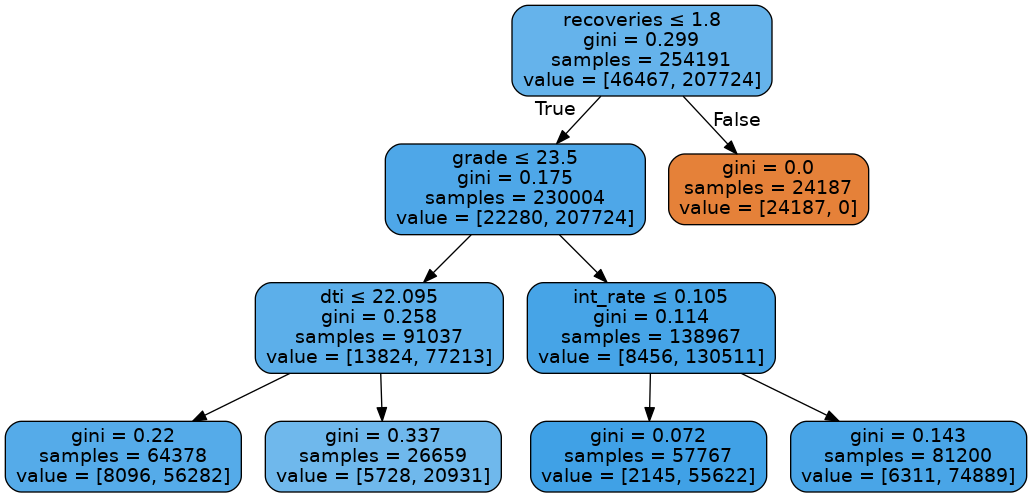

In [0]:
# Draw Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data, feature_names=X_test.columns, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Index([u'loan_amnt', u'int_rate', u'installment', u'grade', u'annual_inc',
       u'verified', u'dti', u'delinq_2yrs', u'inq_last_6mths', u'open_acc',
       u'revol_util', u'total_acc', u'recoveries', u'tot_cur_bal',
       u'total_rev_hi_lim'],
      dtype='object')

In [0]:
Classes desbalanceadas
repetir teste 30 vzs
data augmentation


Estudo de funções de custo para RN com dados desbalanceados (2017) - ppge - > banco de dissertacoes e teses